# [MOTrainer: Measurement Operator Trainer](https://zenodo.org/record/7540443)

An example notebook that reads data and convert it to xarray Dataset with aligned time and space axis.

## Import libraries and set paths

In [37]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt # only for plots

In [38]:
pickle_file_path = "./example_data/example_data.pickle"
nc_file_path = "./dssat_s1/example1_data.nc"
zarr_file_path = "./dssat_s1/data/example1_data.zarr"

## Read the data and explore it

In [39]:
# Read the data
df_all_gpi = pd.read_pickle(pickle_file_path)

In [40]:
df_all_gpi

,lat,lon,data
1,56.125,11.375,sig slop curv ...
2,46.125,6.625,sig slop curv ...
3,53.375,6.125,sig slop curv ...
4,49.375,12.375,sig slop curv ...
5,44.375,0.625,sig slop curv ...


In [41]:
df_all_gpi.iloc[3]["data"]

,sig,slop,curv,TG1,TG2,TG3,WG1,WG2,WG3,BIOMA1,BIOMA2
datetime_doy,,,,,,,,,,,
2007-01-02,-8.774847,-0.118061,-0.001871,282.495667,277.571790,280.432019,0.353169,0.297954,0.316928,0.055779,0.064610
2007-01-03,-8.737255,-0.116761,-0.001753,283.059404,278.609833,279.851678,0.224477,0.336283,0.303121,0.057188,0.007182
2007-01-03,-8.791911,-0.118357,-0.002037,284.386143,278.075722,285.383157,0.378645,0.250349,0.335715,0.062280,0.043909
2007-01-05,-7.962205,-0.118063,-0.002072,276.947048,277.841682,277.941320,0.305945,0.332280,0.315607,0.052877,0.017596
2007-01-06,-8.607216,-0.118727,-0.002048,276.458553,282.783491,277.956962,0.380480,0.364697,0.280530,0.051309,0.034444
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30,-8.824627,-0.119621,-0.000872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,-8.578708,-0.121446,-0.001059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,-8.731547,-0.119538,-0.000887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Convert data

As seen above, the "datetime_doy" values are not unique. While it's possible to have non-unique index values, it's generally not recommended. Having a non-unique index can make certain operations and data manipulation more complex, or even incorrect. These values shows two observation at one day. To avoid duplication, we add a hal-hour shift.

In [42]:
# Function to make timestamps unique by adding half an hour
def make_timestamps_unique(df):
    seen_timestamps = set()
    new_index = []

    for timestamp in df.index:
        if timestamp not in seen_timestamps:
            new_index.append(timestamp)
            seen_timestamps.add(timestamp)
        else:
            # Timestamp is a duplicate, add half an hour
            while timestamp in seen_timestamps:
                timestamp += pd.Timedelta(minutes=30)
            new_index.append(timestamp)
            seen_timestamps.add(timestamp)
    
    df.index = new_index
    df.index.name = "time"
    return df

In [43]:
ds_list = []
for index, row in df_all_gpi.iterrows():
    
    # Filter the nested DataFrame based on location
    df = df_all_gpi.iloc[index-1]["data"]

    # Make timestamps unique
    df = make_timestamps_unique(df)

    # convert dataframe to dataset
    ds = xr.Dataset(df, coords={'latitude': row["lat"], 'longitude': row["lon"]})
    ds_list.append(ds)

# Create one dataset
dataset = xr.concat(ds_list, dim="space")

# Add attribute (metadata)
dataset.attrs['source'] = 'data source'
dataset.attrs['license'] = 'data license'

## Inspect output and store it

In [44]:
dataset

<xarray.Dataset>
Dimensions:    (time: 8506, space: 5)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-02 ... 2020-01-01T01:00:00
    latitude   (space) float64 56.12 46.12 53.38 49.38 44.38
    longitude  (space) float64 11.38 6.625 6.125 12.38 0.625
Dimensions without coordinates: space
Data variables:
    sig        (space, time) float64 -9.49 -8.494 -9.069 ... -8.071 -8.237
    slop       (space, time) float64 -0.1208 -0.1178 -0.121 ... -0.1144 -0.1191
    curv       (space, time) float64 -0.001396 -0.001464 ... -0.0006173
    TG1        (space, time) float64 280.0 270.4 285.5 277.4 ... nan nan nan nan
    TG2        (space, time) float64 274.8 278.4 280.6 283.7 ... nan nan nan nan
    TG3        (space, time) float64 280.9 279.7 278.0 278.0 ... nan nan nan nan
    WG1        (space, time) float64 0.3249 0.2798 0.2773 0.2867 ... nan nan nan
    WG2        (space, time) float64 0.3408 0.2902 0.3373 0.2709 ... nan nan nan
    WG3        (space, time) float64 0.3123 0.2916 0.2891 0.3538 ... nan nan nan
    BIOMA1     (space, time) float64 0.07079 0.05532 0.04846 ... nan nan nan
    BIOMA2     (space, time) float64 0.04366 0.0462 0.03821 ... nan nan nan
Attributes:
    source:   data source
    license:  data license

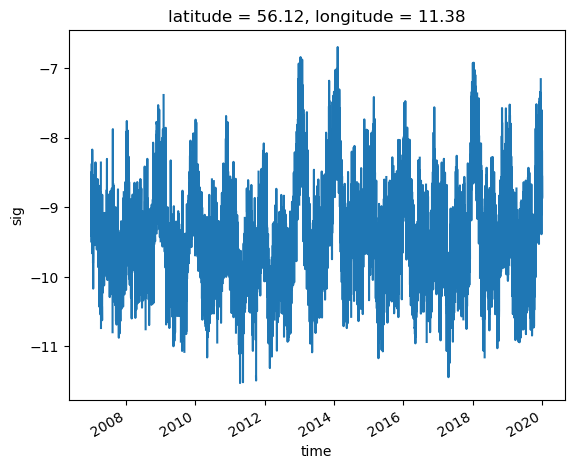

In [45]:
# Time series of one variable at one location
sig = dataset.sig.isel(space=0)
sig.plot()

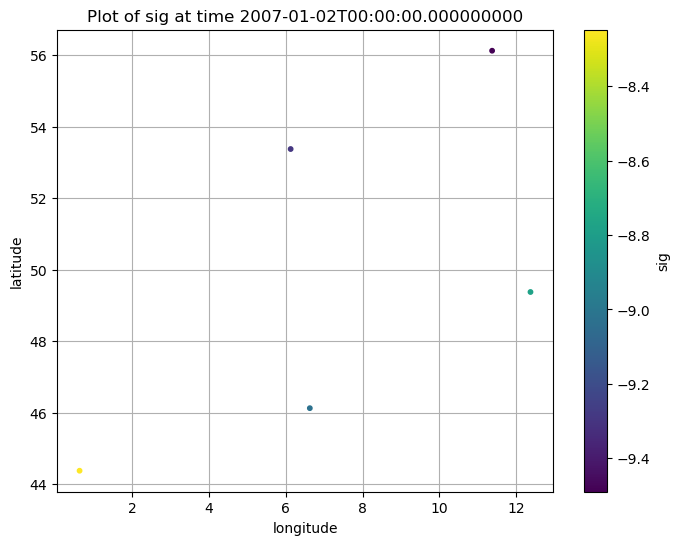

In [46]:
# map of one variable at one time
time = "2007-01-02T00:00:00.000000000"
sig = dataset.sig.sel(time=time)
lons, lats = xr.broadcast(sig.longitude, sig.latitude)
plt.figure(figsize=(8, 6))
plt.scatter(lons, lats, c=sig, cmap="viridis", marker="o", s=10)
plt.colorbar(label="sig") 
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title(f"Plot of sig at time {time}")
plt.grid(True)
plt.show()

In [47]:
# Save data in netcdf format
dataset.to_netcdf(nc_file_path)

In [48]:
# For large dataset, chunk the data and save data in zarr format
dataset.chunk({'space':1000})
dataset.to_zarr(zarr_file_path)